In [2]:
#!pip install kagglehub
import kagglehub
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")
print("Path to dataset files:", path)
df = pd.read_csv(f'{path}/healthcare-dataset-stroke-data.csv')

#Load dataset here


/home/emre/anaconda3/envs/jupyter-kernel/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/emre/.cache/kagglehub/datasets/fedesoriano/stroke-prediction-dataset/versions/1


**Data summary**

Here we see a description of the data. We use functions such as `info()`,`describe()`,and `head()` to see the data summary. And after that we check the data for missing values.
 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:

df.describe() #basic information about the data 

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:

df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:

print("Missing values:\n" , df.isnull().sum())

Missing values:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


**Data balancing and handling missing values**

Previous section showed us that `bmi` attribute has a lot of missing values. To avoid training a model in a biased and incomplete dataset, we need to balance this attribute.
First we check the class imbalance on positive and negative cases on our target variable.

In [7]:
print("Stroke class balance: \n", df['stroke'].value_counts())

Stroke class balance: 
 stroke
0    4861
1     249
Name: count, dtype: int64


**Visualize the class imbalance**


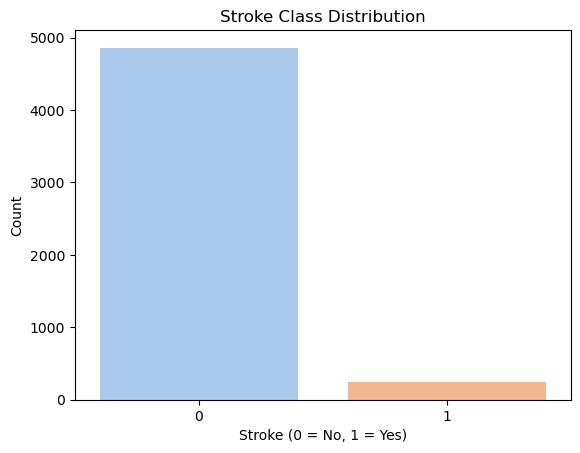

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='stroke', palette='pastel')
plt.title('Stroke Class Distribution')
plt.xlabel('Stroke (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


**Handling Nan values**

We are going to handle missing value in the `bmi` attribute using `Simple Imputer`. How I decided to handle these missing values is replacing Nan's with the median of that column.



In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

imputer = SimpleImputer(strategy='median')
df['bmi'] = imputer.fit_transform(df[['bmi']])

print("Missing values:\n" , df.isnull().sum())


Missing values:
 id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


**Pre-process other data**

Here we replace other in gender for simplicity sake. Then we label encode the binary columns such as `gender` , `ever_married`,and `residence_type`. Then we proceed to One-Hot Encode the multicategoricals. 

In [10]:
#Simplify
df['gender'] = df['gender'].replace('Other', 'Male')

#Label encode 
le = LabelEncoder()

for col in ['gender', 'ever_married', 'Residence_type']:
    df[col] = le.fit_transform(df[col])

#One-hot encode
df = pd.get_dummies(df, columns=['work_type','smoking_status'], drop_first=True)

#Drop ID
if 'id' in df.columns: 
    df = df.drop(columns=['id'])

**Test-train split**

First we would have to split the dataset into train-test splits. Then we are going to attempt to fix the class imbalance only on the train split.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('stroke', axis = 1), 
                                                    df['stroke'], 
                                                    test_size = 0.4, 
                                                    random_state = 42,
                                                    stratify=df['stroke'])

 Scale the dataset on both train and test sets.
    Note that we fit MinMaxScaler on X_train only, not on the entire dataset.
    This prevents data leakage from test set to train set.


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

#pca = PCA(n_components=2)
#X_train_pca = pca.fit_transform(X_train)
#X_test_pca = pca.transform(X_test)


**Baseline model training**

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Logistic Regression (no balancing)
lr_base = LogisticRegression(max_iter=1000)
lr_base.fit(X_train, y_train)
lr_base_pred = lr_base.predict(X_test)

rf_ros_lower_threshold = lr_base.predict_proba(X_test)[:, 1] 
threshold = 0.2
y_pred_lr = (rf_ros_lower_threshold > threshold).astype(int)


In [14]:

# Random Forest (no balancing)
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)
rf_base_pred = rf_base.predict(X_test)

rf_ros_lower_threshold = rf_base.predict_proba(X_test)[:, 1] 
threshold = 0.2
y_pred_rf = (rf_ros_lower_threshold > threshold).astype(int)



In [15]:

print("=== BASELINE (NO BALANCING) ===")
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("Random Forest Accuracy Report:\n", accuracy_score(y_test, y_pred_lr))

print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy Report:\n", accuracy_score(y_test, y_pred_rf))




=== BASELINE (NO BALANCING) ===
Logistic Regression:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      1944
           1       0.22      0.28      0.24       100

    accuracy                           0.92      2044
   macro avg       0.59      0.61      0.60      2044
weighted avg       0.93      0.92      0.92      2044

Random Forest Accuracy Report:
 0.9153620352250489
Random Forest:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1944
           1       0.20      0.27      0.23       100

    accuracy                           0.91      2044
   macro avg       0.58      0.61      0.59      2044
weighted avg       0.92      0.91      0.92      2044

Random Forest Accuracy Report:
 0.9119373776908023


**Balancing the data**

As we saw before the target variable is highly imbalanced. Now we are going to try out a few methods for handling this imbalance. Note that we will only do this on the training set.

**Random oversampling**

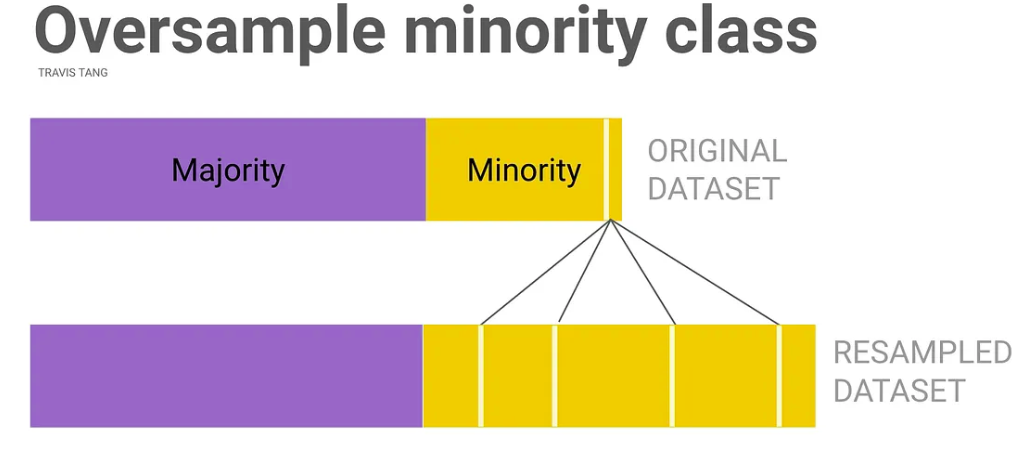

Output of the cell below will make the classes in `stroke` `0` and `1` equal. So while distribution of `df['stroke']` was,

 `stroke`

0    4861

1     249

After applying random oversampling, the minority class will `stroke=1` will be duplicated until it matches the number of samples in the majority class.

`stroke`

1    4861

0    2916

In [16]:
from imblearn.over_sampling import RandomOverSampler
X = df.drop(['stroke'] , axis=1)
Y = df['stroke']

In [17]:
# Perform random oversampling
ros = RandomOverSampler(sampling_strategy=0.6, random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X,Y)

print(y_train_ros.value_counts())


stroke
0    4861
1    2916
Name: count, dtype: int64


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

__Training models on oversamplified data__

In [19]:
# 3. Logistic Regression + ROS
lr_ros = LogisticRegression(random_state=42)
lr_ros.fit(X_train_ros, y_train_ros)  

# 4. Predict
y_pred_proba = lr_ros.predict_proba(X_test)[:, 1] 

# 5. Threshold
threshold = 0.2
y_pred_lr = (y_pred_proba > threshold).astype(int)

print("Logistic Regression: \n", classification_report(y_test, y_pred_lr))

Logistic Regression: 
               precision    recall  f1-score   support

           0       0.99      0.55      0.71      1944
           1       0.09      0.87      0.17       100

    accuracy                           0.57      2044
   macro avg       0.54      0.71      0.44      2044
weighted avg       0.94      0.57      0.68      2044



In [36]:
# Random Forest + ROS
rf_ros = RandomForestClassifier(random_state=42)
rf_ros.fit(X_train_ros, y_train_ros)

# 1. Get the probabilities (Keep this variable name clear)
y_proba_rf = rf_ros.predict_proba(X_test)[:, 1] 

# 2. Apply your custom threshold
threshold = 0.2
y_pred_custom = (y_proba_rf > threshold).astype(int)

# 3. Pass the CUSTOM PREDICTIONS to the report (NOT the probabilities)
print("Random Forest (0.2 Threshold): \n", classification_report(y_test, y_pred_custom))
print("Random Forest Accuracy Report:\n", accuracy_score(y_test, y_pred_custom))

Random Forest (0.2 Threshold): 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1944
           1       0.85      1.00      0.92       100

    accuracy                           0.99      2044
   macro avg       0.92      1.00      0.96      2044
weighted avg       0.99      0.99      0.99      2044

Random Forest Accuracy Report:
 0.9911937377690803


As we see in the results we didnt get anything solid. It is maybe normal for oversampler to fail in this big of a gap between positive cases and negative cases because all it does is take the positive cases and duplicates them. 

**Undersampling Method**

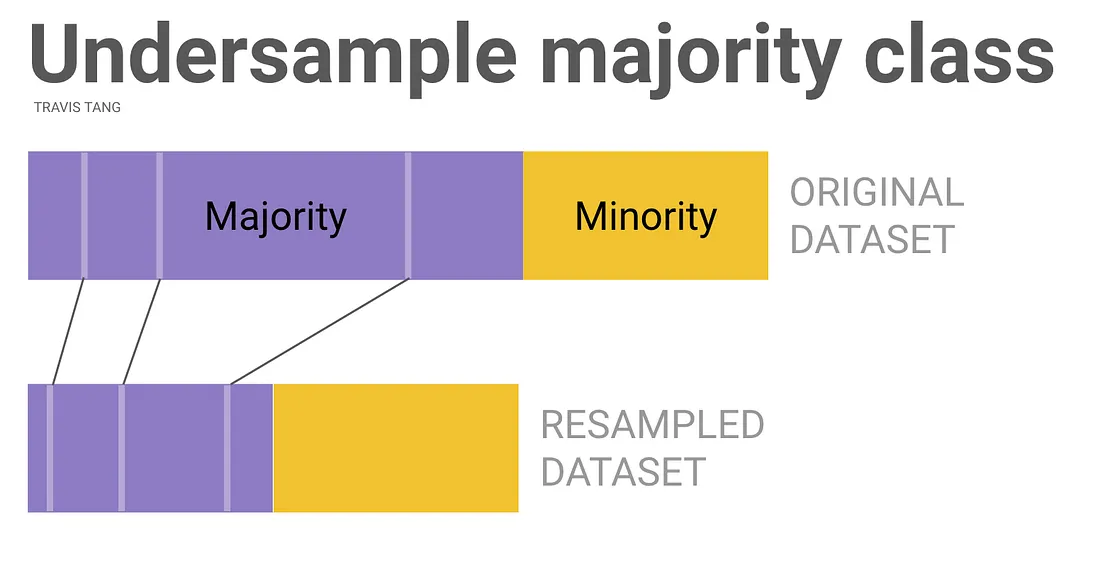


In this method we do the exact opposite. We take the majority class and we undersample it. (Balance Accuracy)


In [21]:
from imblearn.under_sampling import RandomUnderSampler
X = df.drop(['stroke'] , axis=1)
Y = df['stroke']

In [22]:
rf_under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_under, y_train_under = rf_under.fit_resample(X, Y)

The biggest issue with undersampling, in our case, that if you dont have a big enough dataset or if there is a huge gap between negative and positive cases, you will lose a good chunk of your data.

In [23]:
print(y_train_under.value_counts())

stroke
0    498
1    249
Name: count, dtype: int64


In [24]:
# Random Forest + Under Sampling
rf_under = RandomForestClassifier(random_state=42)
rf_under.fit(X_train_under, y_train_under)
rf_under_pred = rf_under.predict(X_test)


# 1. Get the probabilities (Keep this variable name clear)
y_proba_rf = rf_under.predict_proba(X_test)[:, 1] 

# 2. Apply your custom threshold
threshold = 0.5
y_pred_rf_under = (y_proba_rf > threshold).astype(int)

# 3. Pass the CUSTOM PREDICTIONS to the report (NOT the probabilities)
print("Random Forest (0.2 Threshold): \n", classification_report(y_test, y_pred_rf_under))

Random Forest (0.2 Threshold): 
               precision    recall  f1-score   support

           0       1.00      0.84      0.91      1944
           1       0.24      1.00      0.39       100

    accuracy                           0.85      2044
   macro avg       0.62      0.92      0.65      2044
weighted avg       0.96      0.85      0.89      2044



In [35]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
# Train SVC on original data
#clf = SVC(kernel='linear',probability=True)
#clf_ros.fit(X_train_pca, y_train)

# Train SVC on randomly oversampled data
#clf_ros = SVC(kernel='linear',probability=True)
#clf_ros.fit(X_train_ros, y_train_ros)

# Train SVC on randomly undersampled data
clf_rus = SVC(kernel='linear',probability=True)
clf_rus.fit(X_train_under, y_train_under)

def scatter_plot_svc(X, y, model, title):
    # Create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict class using data and trained model
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

scatter_plot_svc(X_train_under.values, y_train_under.values, clf_rus, "SVC with Random Undersampling")

# Function for plotting is in Notebook.
# Insert link here.

ValueError: X has 2 features, but SVC is expecting 15 features as input.

In [26]:
# 3. Logistic Regression + Under Sampling
lr_under = LogisticRegression(random_state=42)
lr_under.fit(X_train_under, y_train_under)  

# 4. Predict
y_pred_proba = lr_under.predict_proba(X_test)[:, 1] 

# 5. Threshold
threshold = 0.3
y_pred_lr = (y_pred_proba > threshold).astype(int)

print("Logistic Regression: \n", classification_report(y_test, y_pred_lr))

Logistic Regression: 
               precision    recall  f1-score   support

           0       0.99      0.68      0.81      1944
           1       0.12      0.82      0.21       100

    accuracy                           0.69      2044
   macro avg       0.55      0.75      0.51      2044
weighted avg       0.94      0.69      0.78      2044



Results are worse than last time. This was expected since we have 700 data points negative+positive total. 

__smote balancing__

In [27]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_sm.value_counts())


After SMOTE:
stroke
0    2917
1    2917
Name: count, dtype: int64


__model trained on smote__

In [28]:
# Logistic Regression + SMOTE
lr_sm = LogisticRegression(max_iter=1000)
lr_sm.fit(X_train_sm, y_train_sm)
lr_sm_pred = lr_sm.predict(X_test)

# Random Forest + SMOTE
rf_sm = RandomForestClassifier(random_state=42)
rf_sm.fit(X_train_sm, y_train_sm)
rf_sm_pred = rf_sm.predict(X_test)

print("=== SMOTE ===")
print("Logistic Regression SMOTE:\n", classification_report(y_test, lr_sm_pred))
print("Random Forest SMOTE:\n", classification_report(y_test, rf_sm_pred))


=== SMOTE ===
Logistic Regression SMOTE:
               precision    recall  f1-score   support

           0       0.97      0.85      0.90      1944
           1       0.13      0.43      0.20       100

    accuracy                           0.83      2044
   macro avg       0.55      0.64      0.55      2044
weighted avg       0.93      0.83      0.87      2044

Random Forest SMOTE:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      1944
           1       0.12      0.13      0.13       100

    accuracy                           0.91      2044
   macro avg       0.54      0.54      0.54      2044
weighted avg       0.91      0.91      0.91      2044



**Threshold Tuning**

we flag strokes even if the model is >30% sure/confident 

In [29]:
# Get predicted probabilities for the 'Stroke' class (column 1) from SMOTE model
y_pred_prob = lr_sm.predict_proba(X_test)[:, 1]

# Set a lower threshold to catch more strokes (30%)
threshold = 0.3
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

print(f"=== Logistic Regression (SMOTE) with Threshold {threshold} ===")
print(classification_report(y_test, y_pred_adjusted))

=== Logistic Regression (SMOTE) with Threshold 0.3 ===
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      1944
           1       0.10      0.57      0.18       100

    accuracy                           0.74      2044
   macro avg       0.54      0.66      0.51      2044
weighted avg       0.93      0.74      0.81      2044



In [30]:

print('Accuracy (LR):', accuracy_score(y_test, lr_sm_pred))
print('Accuracy (RF):', accuracy_score(y_test, rf_sm_pred))

Accuracy (LR): 0.8272994129158513
Accuracy (RF): 0.9114481409001957


__adding xgboost__

In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Initialize XGBoost with a weight parameter to handle imbalance
# scale_pos_weight estimate = total_negative_examples / total_positive_examples
# 4861 / 249 ≈ 19.5 (rounded to 20)
xgb = XGBClassifier(scale_pos_weight=20, eval_metric='logloss', random_state=42)
    
# Train on the original X_train (XGBoost handles the weight internally)
xgb.fit(X_train_sm, y_train_sm)

# Predict
xgb_pred = xgb.predict(X_test)

print("=== XGBOOST (Weighted) ===")
print(classification_report(y_test, xgb_pred))

=== XGBOOST (Weighted) ===
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1944
           1       0.12      0.22      0.16       100

    accuracy                           0.89      2044
   macro avg       0.54      0.57      0.55      2044
weighted avg       0.92      0.89      0.90      2044



__model comp__


In [32]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def results_row(model, balancing, y_true, y_pred):
    return {
        "Model": model,
        "Balancing": balancing,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

results = []

results.append(results_row("Logistic Regression", "None", y_test, lr_base_pred))
results.append(results_row("Random Forest", "None", y_test, rf_base_pred))

results.append(results_row("Logistic Regression", "Random Oversampling", y_test, lr_ros_pred))
results.append(results_row("Random Forest", "Random Oversampling", y_test, rf_ros_pred))

results.append(results_row("Logistic Regression", "SMOTE", y_test, lr_sm_pred))
results.append(results_row("Random Forest", "SMOTE", y_test, rf_sm_pred))

results_df = pd.DataFrame(results)
results_df


NameError: name 'lr_ros_pred' is not defined

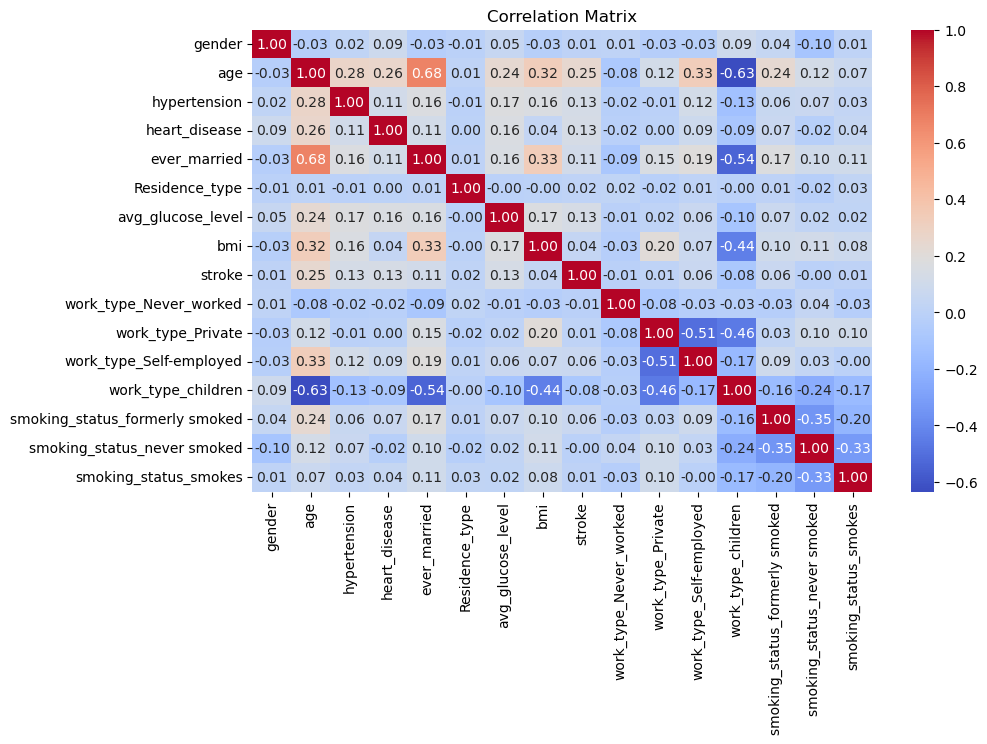

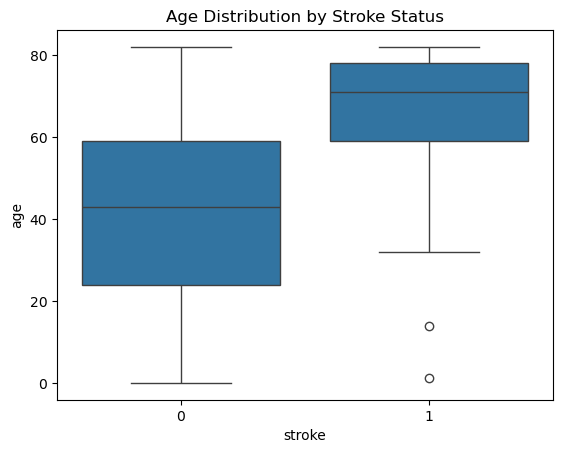

In [ ]:
# Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Stroke vs Age (Boxplot) - To show strokes happen more to older people
sns.boxplot(x='stroke', y='age', data=df)
plt.title('Age Distribution by Stroke Status')
plt.show()

__feature importance__

In [ ]:
import matplotlib.pyplot as plt

feature_names = df.drop('stroke', axis=1).columns
importances = rf_sm.feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("Top 10 Important Features:")
print(feat_imp.head(10))


Top 10 Important Features:
age                            0.378434
bmi                            0.139441
avg_glucose_level              0.120157
ever_married                   0.067467
hypertension                   0.052982
heart_disease                  0.039498
Residence_type                 0.036544
gender                         0.035126
work_type_Private              0.027290
smoking_status_never smoked    0.026132
dtype: float64


__plot__

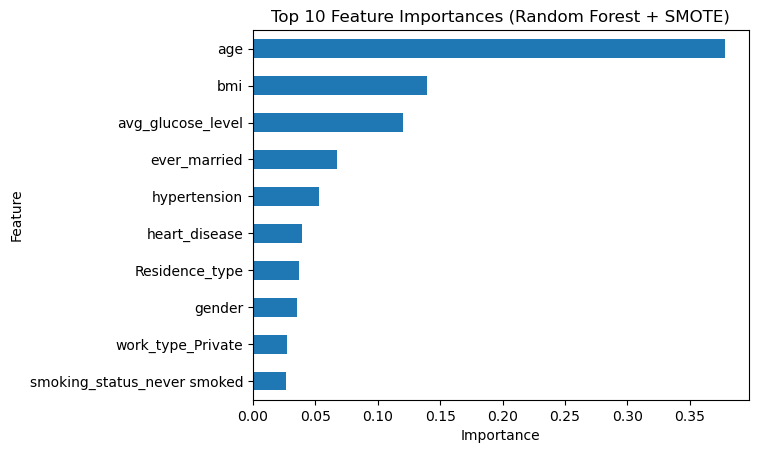

In [ ]:
feat_imp.head(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest + SMOTE)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()
